In [2]:
import pandas as pd
import tensorflow
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [3]:
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

In [4]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.40))
model.add(Dense(7, activation = 'sigmoid'))

In [5]:
data = pd.read_csv('HAM10000_metadata.csv')

In [6]:
data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
data['img_full_name'] = data['image_id'] + '.jpg'
X = data[['img_full_name', 'dx', 'lesion_id']]

In [8]:
X

,img_full_name,dx,lesion_id
0,ISIC_0027419.jpg,bkl,HAM_0000118
1,ISIC_0025030.jpg,bkl,HAM_0000118
2,ISIC_0026769.jpg,bkl,HAM_0002730
3,ISIC_0025661.jpg,bkl,HAM_0002730
4,ISIC_0031633.jpg,bkl,HAM_0001466
...,...,...,...
10010,ISIC_0033084.jpg,akiec,HAM_0002867
10011,ISIC_0033550.jpg,akiec,HAM_0002867
10012,ISIC_0033536.jpg,akiec,HAM_0002867
10013,ISIC_0032854.jpg,akiec,HAM_0000239


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
Y = X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.17, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.17, random_state = 42)

In [11]:
train = pd.concat([X_train, y_train], axis = 1)
val = pd.concat([X_val, y_val], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [12]:
from sklearn.preprocessing import LabelEncoder

In [49]:
encoder = LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train = encoder.transform(val['dx'])
val['label'] = name_as_indexes_train

In [14]:
pip install Keras-Preprocessing

Note: you may need to restart the kernel to use updated packages.


In [15]:
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=10,
                                     zoom_range=0.1,
                                     width_shift_range=0.0,
                                     height_shift_range=0.0
                                     )

In [16]:
train_data = train_generator.flow_from_dataframe(dataframe=train, 
                                                 x_col="img_full_name",
                                                 y_col="dx",
                                                 batch_size=32,
                                                 directory='HAM1000_images',
                                                 shuffle=True,
                                                 class_mode='categorical',
                                                 target_size=(224, 224)
                                                 )

Found 6898 validated image filenames belonging to 7 classes.


In [17]:
test_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,
                                    zoom_range=0.1,
                                    width_shift_range=0.0,
                                    height_shift_range=0.02
                                    )

In [18]:
test_generator

In [19]:
test_data = test_generator.flow_from_dataframe(dataframe=test,
                                               x_col="img_full_name",
                                               y_col="dx",
                                               directory='HAM1000_images',
                                               shuffle=False,
                                               batch_size=1,
                                               class_mode=None,
                                               target_size=(224, 224)
                                               )

Found 1703 validated image filenames.


In [20]:
val_data = test_generator.flow_from_dataframe(dataframe=val,
                                              x_col="img_full_name",
                                              y_col="dx",
                                              directory='HAM1000_images',
                                              batch_size=64,
                                              shuffle=False,
                                              class_mode='categorical',
                                              target_size=(224, 224)
                                              )

Found 1414 validated image filenames belonging to 7 classes.


In [21]:
from keras.callbacks import ReduceLROnPlateau

In [31]:
learning_control = ReduceLROnPlateau(monitor='val_acc',
                                     patience=3,
                                     verbose=1,
                                     factor=.5,
                                     min_lr=1
                                     )

In [23]:
from keras.optimizers import Adam, SGD

In [26]:
sgd = SGD(learning_rate=0.1,
          clipvalue=0.5
          )

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [27]:
history = model.fit_generator(generator=train_data,
                              steps_per_epoch=train_data.samples//train_data.batch_size,
                              validation_data=val_data,
                              verbose=1,
                              validation_steps=val_data.samples//val_data.batch_size,
                              epochs=30,
                              callbacks=[learning_control]
                              )

C:\Users\User\AppData\Local\Temp\ipykernel_2368\2312142227.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data,


Epoch 1/30
215/215 [==============================] - ETA: 0s - loss: 1.3966 - accuracy: 0.6621WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1312s 6s/step - loss: 1.3966 - accuracy: 0.6621 - val_loss: 1.4506 - val_accuracy: 0.6733 - lr: 0.1000
Epoch 2/30
215/215 [==============================] - ETA: 0s - loss: 0.9425 - accuracy: 0.6701WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1203s 6s/step - loss: 0.9425 - accuracy: 0.6701 - val_loss: 1.4872 - val_accuracy: 0.6733 - lr: 0.1000
Epoch 3/30
215/215 [==============================] - ETA: 0s - loss: 0.8908 - accuracy: 0.6751WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1247s 6s/step - loss: 0.8908 - accuracy: 0.6751 - val_loss: 1.5329 - val_accuracy: 0.6733 - lr: 0.1000
Epoch 4/30
215/215 [==============================] - ETA: 0s - loss: 0.8537 - accuracy: 0.6850WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1309s 6s/step - loss: 0.8537 - accuracy: 0.6850 - val_loss: 1.6252 - val_accuracy: 0.0902 - lr: 0.1000
Epoch 5/30
215/215 [==============================] - ETA: 0s - loss: 0.8267 - accuracy: 0.6899WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1314s 6s/step - loss: 0.8267 - accuracy: 0.6899 - val_loss: 1.6876 - val_accuracy: 0.0959 - lr: 0.1000
Epoch 6/30
215/215 [==============================] - ETA: 0s - loss: 0.8040 - accuracy: 0.6965WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1324s 6s/step - loss: 0.8040 - accuracy: 0.6965 - val_loss: 1.4498 - val_accuracy: 0.4460 - lr: 0.1000
Epoch 7/30
215/215 [==============================] - ETA: 0s - loss: 0.7878 - accuracy: 0.6975WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1301s 6s/step - loss: 0.7878 - accuracy: 0.6975 - val_loss: 1.1658 - val_accuracy: 0.6761 - lr: 0.1000
Epoch 8/30
215/215 [==============================] - ETA: 0s - loss: 0.7696 - accuracy: 0.7107WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1164s 5s/step - loss: 0.7696 - accuracy: 0.7107 - val_loss: 1.5348 - val_accuracy: 0.6662 - lr: 0.1000
Epoch 9/30
215/215 [==============================] - ETA: 0s - loss: 0.7554 - accuracy: 0.7256WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1191s 6s/step - loss: 0.7554 - accuracy: 0.7256 - val_loss: 1.1487 - val_accuracy: 0.6179 - lr: 0.1000
Epoch 10/30
215/215 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.7221WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1153s 5s/step - loss: 0.7299 - accuracy: 0.7221 - val_loss: 1.2173 - val_accuracy: 0.5355 - lr: 0.1000
Epoch 11/30
215/215 [==============================] - ETA: 0s - loss: 0.7160 - accuracy: 0.7426WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1155s 5s/step - loss: 0.7160 - accuracy: 0.7426 - val_loss: 1.3141 - val_accuracy: 0.6783 - lr: 0.1000
Epoch 12/30
215/215 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.7476WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1155s 5s/step - loss: 0.7007 - accuracy: 0.7476 - val_loss: 0.7509 - val_accuracy: 0.7301 - lr: 0.1000
Epoch 13/30
215/215 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.7571WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1127s 5s/step - loss: 0.6777 - accuracy: 0.7571 - val_loss: 0.8848 - val_accuracy: 0.6861 - lr: 0.1000
Epoch 14/30
215/215 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.7683WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1147s 5s/step - loss: 0.6522 - accuracy: 0.7683 - val_loss: 1.1533 - val_accuracy: 0.6307 - lr: 0.1000
Epoch 15/30
215/215 [==============================] - ETA: 0s - loss: 0.6405 - accuracy: 0.7734WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1149s 5s/step - loss: 0.6405 - accuracy: 0.7734 - val_loss: 0.8590 - val_accuracy: 0.6989 - lr: 0.1000
Epoch 16/30
215/215 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.7722WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1205s 6s/step - loss: 0.6251 - accuracy: 0.7722 - val_loss: 0.9710 - val_accuracy: 0.6903 - lr: 0.1000
Epoch 17/30
215/215 [==============================] - ETA: 0s - loss: 0.6134 - accuracy: 0.7775WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1301s 6s/step - loss: 0.6134 - accuracy: 0.7775 - val_loss: 2.0462 - val_accuracy: 0.6854 - lr: 0.1000
Epoch 18/30
215/215 [==============================] - ETA: 0s - loss: 0.5930 - accuracy: 0.7926WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1426s 7s/step - loss: 0.5930 - accuracy: 0.7926 - val_loss: 1.1829 - val_accuracy: 0.6825 - lr: 0.1000
Epoch 19/30
215/215 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.7983WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1320s 6s/step - loss: 0.5776 - accuracy: 0.7983 - val_loss: 1.2068 - val_accuracy: 0.6470 - lr: 0.1000
Epoch 20/30
215/215 [==============================] - ETA: 0s - loss: 0.5612 - accuracy: 0.8010WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1290s 6s/step - loss: 0.5612 - accuracy: 0.8010 - val_loss: 0.7883 - val_accuracy: 0.7095 - lr: 0.1000
Epoch 21/30
215/215 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.8010  WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 15305s 71s/step - loss: 0.5530 - accuracy: 0.8010 - val_loss: 1.1402 - val_accuracy: 0.6143 - lr: 0.1000
Epoch 22/30
215/215 [==============================] - ETA: 0s - loss: 0.5432 - accuracy: 0.8111WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1169s 5s/step - loss: 0.5432 - accuracy: 0.8111 - val_loss: 0.9561 - val_accuracy: 0.7216 - lr: 0.1000
Epoch 23/30
215/215 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.8203WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1166s 5s/step - loss: 0.5095 - accuracy: 0.8203 - val_loss: 0.9017 - val_accuracy: 0.7131 - lr: 0.1000
Epoch 24/30
215/215 [==============================] - ETA: 0s - loss: 0.5188 - accuracy: 0.8162WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1172s 5s/step - loss: 0.5188 - accuracy: 0.8162 - val_loss: 1.0666 - val_accuracy: 0.6477 - lr: 0.1000
Epoch 25/30
215/215 [==============================] - ETA: 0s - loss: 0.4949 - accuracy: 0.8241WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1165s 5s/step - loss: 0.4949 - accuracy: 0.8241 - val_loss: 0.8595 - val_accuracy: 0.6882 - lr: 0.1000
Epoch 26/30
215/215 [==============================] - ETA: 0s - loss: 0.4705 - accuracy: 0.8296WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1166s 5s/step - loss: 0.4705 - accuracy: 0.8296 - val_loss: 0.8135 - val_accuracy: 0.7457 - lr: 0.1000
Epoch 27/30
215/215 [==============================] - ETA: 0s - loss: 0.4803 - accuracy: 0.8321WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1147s 5s/step - loss: 0.4803 - accuracy: 0.8321 - val_loss: 1.0725 - val_accuracy: 0.7109 - lr: 0.1000
Epoch 28/30
215/215 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.8378WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1150s 5s/step - loss: 0.4611 - accuracy: 0.8378 - val_loss: 0.8966 - val_accuracy: 0.7202 - lr: 0.1000
Epoch 29/30
215/215 [==============================] - ETA: 0s - loss: 0.4520 - accuracy: 0.8391WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1145s 5s/step - loss: 0.4520 - accuracy: 0.8391 - val_loss: 0.9997 - val_accuracy: 0.7109 - lr: 0.1000
Epoch 30/30
215/215 [==============================] - ETA: 0s - loss: 0.4288 - accuracy: 0.8504WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


215/215 [==============================] - 1180s 5s/step - loss: 0.4288 - accuracy: 0.8504 - val_loss: 1.0056 - val_accuracy: 0.7038 - lr: 0.1000


In [28]:
model.save('model12345.h5')

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


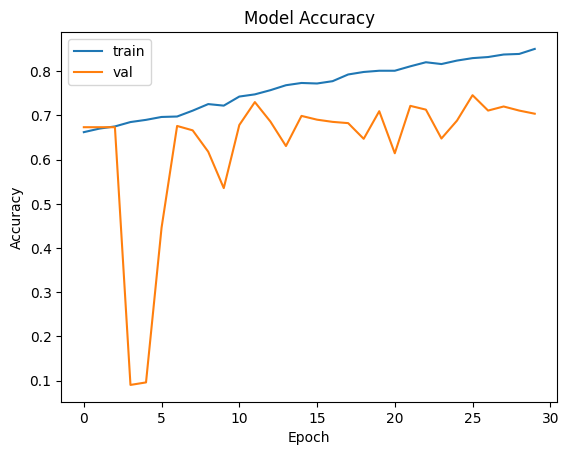

In [33]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

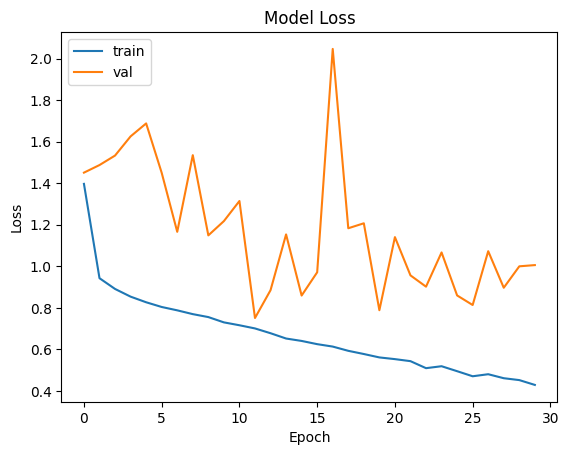

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

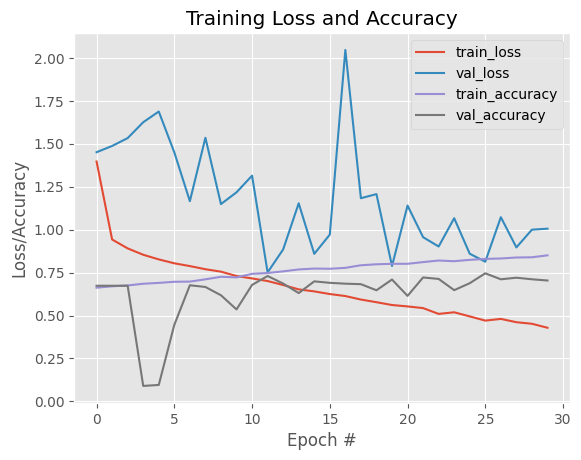

In [38]:
from cProfile import label


N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc = "upper right")

In [39]:
test_data.reset()
predictions = model.predict_generator(test_data, 
                                      steps = test_data.samples/test_data.batch_size, 
                                      verbose = 1
                                      )
y_pred = np.argmax(predictions, axis = 1)

C:\Users\User\AppData\Local\Temp\ipykernel_2368\1298548769.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data,


1703/1703 [==============================] - 128s 75ms/step


In [76]:
c=np.isin(y_pred ,name_as_indexes_train)
print(c)
np.size(c)

[ True  True  True ...  True  True  True]


1703

In [83]:
print(np.count_nonzero(c))
print(len(name_as_indexes_train))

1703
1414


In [94]:
print("Test Accuracy :",(len(name_as_indexes_train)/np.count_nonzero(c)) *100, "%")

Test Accuracy : 83.02994715208456 %


In [102]:
from sklearn.metrics import classification_report
# y_pred = y_pred[:len(name_as_indexes_train)]
report = classification_report(name_as_indexes_train, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        54
           1       0.09      0.09      0.09        77
           2       0.10      0.13      0.11       129
           3       0.00      0.00      0.00        15
           4       0.14      0.17      0.15       169
           5       0.68      0.62      0.65       950
           6       0.00      0.00      0.00        20

    accuracy                           0.45      1414
   macro avg       0.14      0.14      0.14      1414
weighted avg       0.49      0.45      0.47      1414



In [104]:
model.save('mobileNet_new_model.h5')